In [2]:
from pcntoolkit.util.hbr_utils import *
import numpy as np
import pickle
from matplotlib import pyplot as plt
from pcntoolkit.util.utils import scaler
from pcntoolkit.normative import estimate, predict, evaluate
from pcntoolkit.util.utils import compute_MSLL, create_design_matrix
from pcntoolkit.util.utils import calibration_descriptives
from matplotlib import patches
plt.rc('axes', axisbelow=True)


cols = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [3]:
features = ['Right-Cerebellum-White-Matter',
            'EstimatedTotalIntraCranialVol',
            'Right-Lateral-Ventricle',
            'WM-hypointensities',
            'rh_S_interm_prim-Jensen_thickness', 
            'Brain-Stem',
            'log_WM-hypointensities']

selected_feature = features[3]

In [4]:
# Get data
X_train = pickle.load(open("/project_cephfs/3022017.02/projects/stijdboe/Data/10_folds_sexcov/fold_0/X_train.pkl",'rb')).to_numpy()
Y_train = pickle.load(open("/project_cephfs/3022017.02/projects/stijdboe/Data/10_folds_sexcov/fold_0/Y_train.pkl",'rb'))
Z_train = pickle.load(open("/project_cephfs/3022017.02/projects/stijdboe/Data/10_folds_sexcov/fold_0/Z_train.pkl",'rb')).to_numpy()
X_test = pickle.load(open("/project_cephfs/3022017.02/projects/stijdboe/Data/10_folds_sexcov/fold_0/X_test.pkl",'rb')).to_numpy()
Y_test = pickle.load(open("/project_cephfs/3022017.02/projects/stijdboe/Data/10_folds_sexcov/fold_0/Y_test.pkl",'rb'))
Z_test = pickle.load(open("/project_cephfs/3022017.02/projects/stijdboe/Data/10_folds_sexcov/fold_0/Z_test.pkl",'rb')).to_numpy()

In [5]:
# Make synthetic data
X_synth = np.linspace(np.min(X_train[:,0]),np.max(X_train[:,0]),200)[:,None]
Z_synth = np.ones(200)
X_synth = np.concatenate((X_synth, np.ones_like(X_synth)), axis = 1)

_, indices_train, inverse_train = np.unique(Z_train, return_inverse = True, return_index=True)
train_sort = np.argsort(indices_train)


all_sites, indices_test, inverse_test = np.unique(Z_test, return_inverse = True, return_index=True)
test_sort = np.argsort(indices_test)

print(len(all_sites))
Phi_synth = create_design_matrix(X=X_synth, site_ids = Z_synth, all_sites = all_sites)

# Store synthetic data
projdir = '/project_cephfs/3022017.02/projects/stijdboe/make_results/10_folds_results/'
textfiles = os.path.join(projdir,'textfiles')
if not os.path.exists(textfiles):
    os.mkdir(textfiles)
    
np.savetxt(os.path.join(textfiles,'Phi_synth.txt'), Phi_synth)

74


In [17]:
def plot_blr_quantiles(fold = 0, feature ="Right-Lateral-Ventricle", selected_sex='male', areas = []):
    f_idx = features.index(feature)
    outscaler = scaler('standardize')
    outscaler.fit(Y_train[feature])
    model_path = f'10_folds_results/fold_{fold}_blr/batch_{f_idx+1}/Models/NM_0_0_estimate.pkl'
    with open(model_path,'rb') as file:
        model = pickle.load(file)
    Yhat, s2 = model.predict(Phi_synth)
    n_warp_params = model.blr.warp.get_n_params()
    warp_params = model.blr.hyp[1:n_warp_params+1]
    fig = plt.figure(figsize=(5,4))
    
    def warp_and_scale(y):
        return model.warp.f(outscaler.transform(y), warp_params)
    
    def inv_warp_and_scale(y):
        return outscaler.inverse_transform(model.warp.invf(y, warp_params))
    s = np.sqrt(s2)
    site_offsets = model.blr.m[3:len(all_sites)+3]
    plt.plot(X_synth[:,0], inv_warp_and_scale(Yhat), color = 'black')
    plt.plot(X_synth[:,0], inv_warp_and_scale(Yhat+1*s), alpha = 0.4,color='black', linewidth=1)
    plt.plot(X_synth[:,0], inv_warp_and_scale(Yhat-1*s), alpha = 0.4, color='black', linewidth=1)
    plt.plot(X_synth[:,0], inv_warp_and_scale(Yhat+2*s), alpha = 0.4, color='black', linewidth=1)
    plt.plot(X_synth[:,0], inv_warp_and_scale(Yhat-2*s), alpha = 0.4, color='black', linewidth=1)
    plt.plot(X_synth[:,0], inv_warp_and_scale(Yhat+3*s), alpha = 0.4, color='black', linewidth=1, linestyle = "--")
    plt.plot(X_synth[:,0], inv_warp_and_scale(Yhat-3*s), alpha = 0.4, color='black', linewidth=1, linestyle = "--")
    
    selected_sex_id = 0 if selected_sex == 'female' else 1
    train_sex_idx = np.where(X_train[:,1]==selected_sex_id)
    test_sex_idx = np.where(X_test[:,1]==selected_sex_id)

    Y_train_offset = inv_warp_and_scale(warp_and_scale(Y_train[feature].to_numpy())-site_offsets[inverse_train])
    Y_test_offset = inv_warp_and_scale(warp_and_scale(Y_test[feature].to_numpy())-site_offsets[inverse_test])

    maxy = np.max(Y_train[feature].to_numpy()[train_sex_idx])
    miny = np.min(Y_train[feature].to_numpy()[train_sex_idx])
    dify = maxy - miny
    plt.ylim(miny - 0.1*dify, maxy + 0.1*dify )
    
    plt.scatter(X_train[train_sex_idx,0], Y_train_offset[train_sex_idx], alpha = 0.1, s  =12, color=cols[0])
    plt.scatter(X_test[test_sex_idx,0], Y_test_offset[test_sex_idx], alpha = 0.1, s  =12, color=cols[1])
    
    difX = np.max(X_train[:,0])-np.min(X_train[:,0])
    min0 = np.min(X_train[:,0]) + 0.01*difX
    max0 = np.max(X_train[:,0]) - 0.01*difX
    
    for area in areas:
        n,a,b,c,d,e,f = area
        rect = patches.Rectangle((a,b),c,d,label=n, linewidth=1,edgecolor = 'red',facecolor='None',zorder=10)
        plt.gca().add_patch(rect)
        plt.text(a+e*c, b+f*d, n, color='red',fontsize=16)
    if len(areas) > 0:
        suffix = '_ann'
    else:
        suffix = ''
        
    
    plt.title('W-BLR', fontsize=16)
    plt.xlabel('Age',fontsize=15)
#     plt.ylabel(feature,fontsize=12)
    plt.xlim(min0,max0)

    # plt.title(lmap[l], fontsize = 16)
    plt.xlabel('Age',fontsize=15)
#     plt.ylabel(feature,fontsize=12)
    plt.ticklabel_format(axis='y',style='sci', scilimits=(0,0),useMathText=True)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid(linestyle=":", linewidth=1, alpha=0.7)
    fig.axes[0].yaxis.offsetText.set_fontsize(14)
    plt.savefig(f"/home/preclineu/stijdboe/Projects/MasterThesis/Latex/Thesis/imgs/blr_quantile_plot_{feature}{suffix}.png",bbox_inches='tight',dpi=300)
    plt.show()
    # plt.close()
    # plt.plot(X_synth[:,0],Phi_synth@model.blr.m, color='black')
    # plt.plot(X_synth[:,0],Phi_synth@model.blr.m+s, color='black', linestyle=":")
    # plt.plot(X_synth[:,0],Phi_synth@model.blr.m-s, color='black', linestyle= ":")
    # plt.show()

#     plt.plot(X_synth[:,0], model.warp.invf(Yhat-s2*0.4, warp_params))


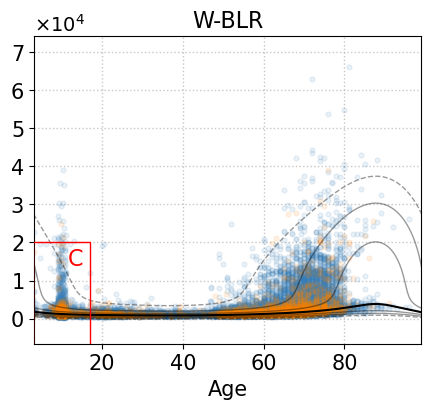

In [18]:
plot_blr_quantiles(feature='WM-hypointensities', areas = [('C',3,-1e4,14,3e4,0.6, 0.8)])

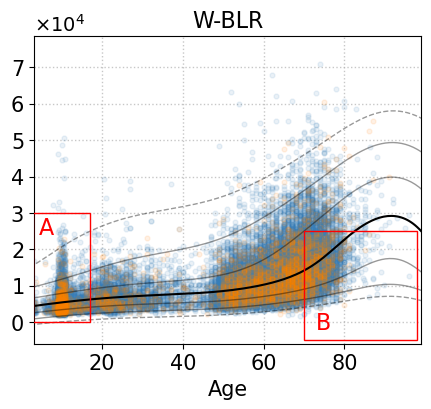

In [19]:
plot_blr_quantiles(feature='Right-Lateral-Ventricle',areas = [('A',3,0,14,3e4,0.1, 0.8), ('B',70,-5000,28,30000, 0.1, 0.1)])

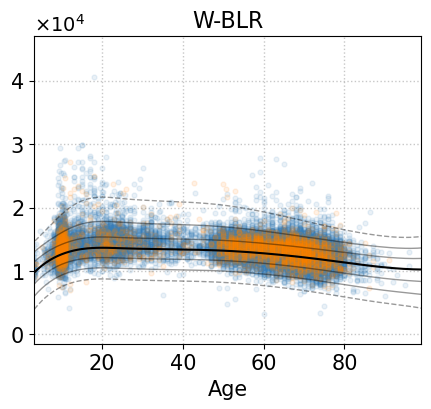

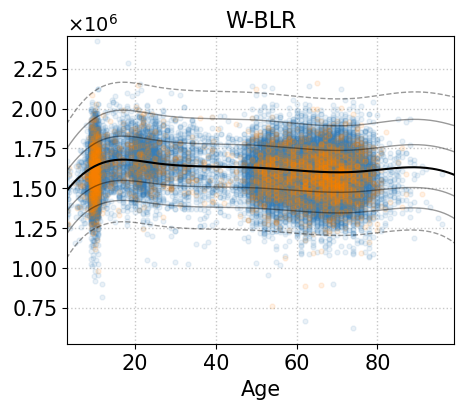

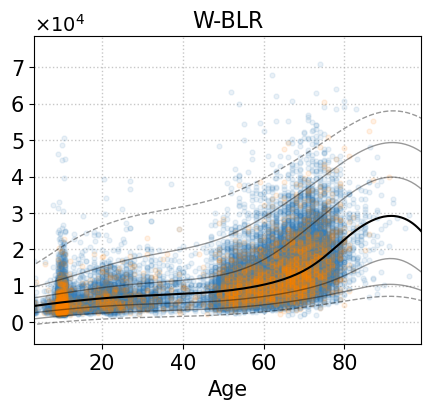

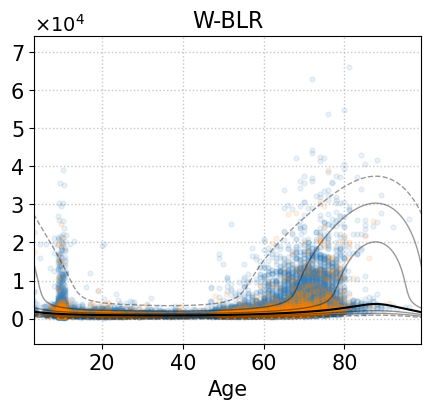

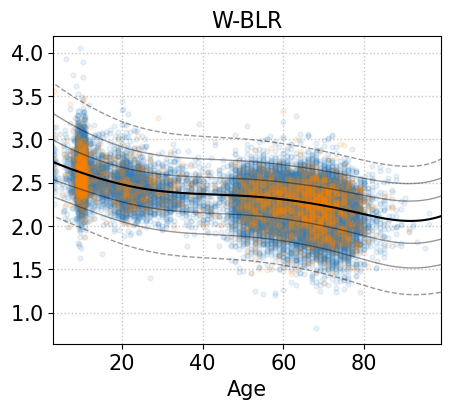

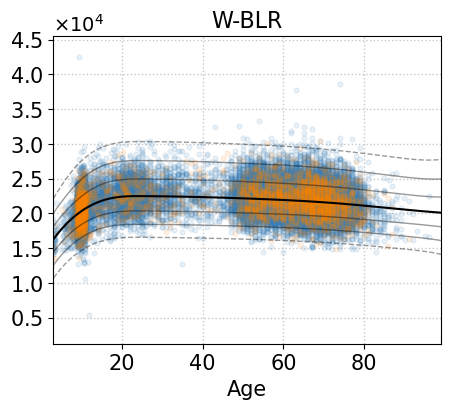

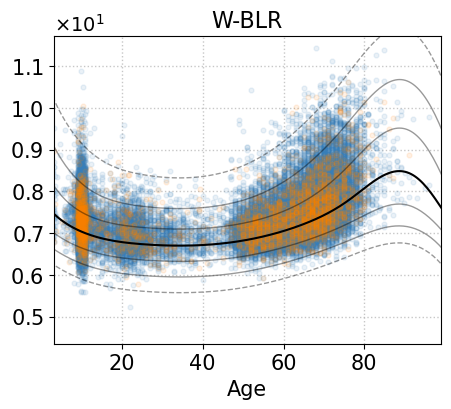

In [20]:
for f in features:
    plot_blr_quantiles(fold=0,feature=f)
        # plot_MAP_quantiles(l='SHASHb', feature=f)

# plot_MAP_quantiles(postfix2='True',feature=selected_feature, selected_sex = 'female')

In [21]:
plot_MAP_quantiles(postfix2='True', selected_sex = 'male')
plot_MAP_quantiles(postfix2='True', selected_sex = 'female')

NameError: name 'plot_MAP_quantiles' is not defined

(200, 1)
(1,)
(200,)
(200, 14)
(200, 1)
(1,)
(200,)
(200, 14)
(200, 1)
(1,)
(200,)
(200, 14)
(200, 1)
(1,)
(200,)
(200, 14)


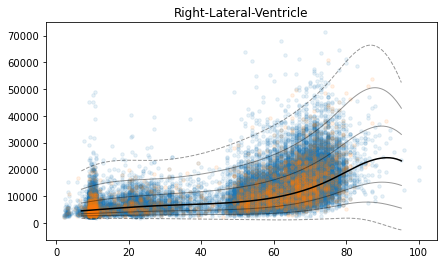

In [11]:
plot_MAP_quantiles(l = 'SHASHb',feature=  'Right-Lateral-Ventricle')

In [10]:
dim1 = 10

all_bes = np.unique(np.random.randint(0,dim1,size=(10,2)), axis = 0)

az = np.random.randn(dim1, dim1)
for be in all_bes:
    print(be)
    
    bet = tuple(be)
    print(az[bet])

[0 0]
0.8975569670019615
[0 5]
-0.7372921940388589
[2 6]
0.2926387619774334
[3 0]
0.5139866033288966
[3 2]
0.3198717260198283
[5 0]
0.010077214480161646
[5 4]
-1.8668029316129853
[8 4]
-0.4144231171312049
[8 5]
1.1591333558913104
[9 2]
-0.034921078527202644
